# Word Embeddings and Neural Ranking with Hugging Face


## Table of Contents
- [Introduction to Word Embeddings](#introduction-to-word-embeddings)
- [Contextual vs Non-Contextual Embeddings](#contextual-vs-non-contextual-embeddings)
- [Generating Word Embeddings with BERT](#generating-word-embeddings-with-bert)
  - [Tokenizing and Extracting Embeddings](#tokenizing-and-extracting-embeddings)
- [Sentence Embeddings with Sentence Transformers](#sentence-embeddings-with-sentence-transformers)
- [Word-level Embeddings with BERT](#word-level-embeddings-with-bert)
- [Sentence-level Embeddings with Sentence Transformers](#sentence-level-embeddings-with-sentence-transformers)
- [Bi-Encoder Model for Neural Ranking](#bi-encoder-model-for-neural-ranking)
- [Cross-Encoder Model for Neural Ranking](#cross-encoder-model-for-neural-ranking)

In [ ]:
!pip install transformers sentence-transformers torch numpy

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy import dot
from numpy.linalg import norm
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
! pip install gensim

In [ ]:
import gensim
import gensim.downloader as api


## [Introduction to Word Embeddings](#introduction-to-word-embeddings)

Word embeddings are dense, low-dimensional vectors that capture semantic and syntactic relationships between words or sentences. Unlike sparse one-hot encodings, embeddings position semantically similar items (e.g., "dog" and "puppy") closer in a continuous vector space. This tutorial covers:

0. Non-contextual embeddings

    word2vec and GloVe


1. Contextual embeddings with BERT

    Word meaning depends on context (e.g., “king” in different sentences).

2. Sentence embeddings with Sentence Transformers

    Efficient, high-quality representations of entire sentences.

3. Neural ranking with bi-encoders

    Queries and documents are encoded independently, then compared with cosine similarity.

    Scales well to large collections because you can pre-compute embeddings.

4. Neural ranking with cross-encoders

    The query and document are encoded together, so the model can attend across tokens in both.

    More accurate, but slower because you can’t pre-compute document embeddings and you must run the model for every query–document pair whenever needed.

**Contextual vs Non-Contextual Embeddings**

1. Non-contextual embeddings (Word2Vec, GloVe):

    Each word has a fixed vector regardless of the sentence.

    "king" will always map to the same vector.

2. Contextual embeddings (BERT, RoBERTa, etc.):

    Each word’s embedding depends on the sentence it appears in.

    "king" in "The king ruled the kingdom" is different from "He bought a king-sized bed".


In [ ]:
def cosine_similarity(a, b):
    return dot(a, b) / (norm(a) * norm(b))


# Load pre-trained Word2Vec embeddings
w2v = api.load("word2vec-google-news-300")  # 300-dim



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
king_vec = w2v["king"]
queen_vec = w2v["queen"]
man_vec = w2v["man"]
woman_vec = w2v["woman"]

print("king vs queen:", cosine_similarity(king_vec, queen_vec))
print("king vs man:", cosine_similarity(king_vec, man_vec))
print("king vs woman:", cosine_similarity(king_vec, woman_vec))
print("queen vs woman:", cosine_similarity(queen_vec, woman_vec))


king vs queen: 0.6510956
king vs man: 0.22942673
king vs woman: 0.12847975
queen vs woman: 0.31618142


In [ ]:
# Load pre-trained GloVe embeddings (50-dimensional version for speed)
glove = api.load("glove-wiki-gigaword-50")

# "king" has the same embedding no matter the sentence
king_vec = glove["king"]
queen_vec = glove["queen"]
man_vec = glove["man"]
woman_vec = glove["woman"]

print("Embedding for 'king' (first 5 dims):", king_vec[:5])
print("Embedding for 'queen' (first 5 dims):", queen_vec[:5])


print("\nCosine Similarities:")
print("king vs queen:", cosine_similarity(king_vec, queen_vec))
print("king vs man:", cosine_similarity(king_vec, man_vec))
print("king vs woman:", cosine_similarity(king_vec, woman_vec))
print("queen vs woman:", cosine_similarity(queen_vec, woman_vec))


[==================================================] 100.0% 66.0/66.0MB downloaded
Embedding for 'king' (first 5 dims): [ 0.50451   0.68607  -0.59517  -0.022801  0.60046 ]
Embedding for 'queen' (first 5 dims): [ 0.37854  1.8233  -1.2648  -0.1043   0.35829]

Cosine Similarities:
king vs queen: 0.7839044
king vs man: 0.5309377
king vs woman: 0.41133782
queen vs woman: 0.60031056


## Word-level Embeddings with BERT

* BERT produces token-level embeddings (contextual).

* Each word's vector depends on surrounding words.

* The [CLS] token can roughly represent a sentence, but it’s not optimized for semantic similarity.

* Example: visualize embeddings of "man", "woman", "king", "queen" from bert-base-uncased.

The ideal visualization of these words would be like this:


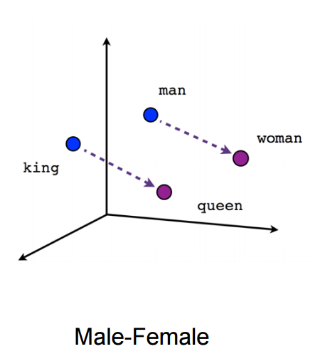

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

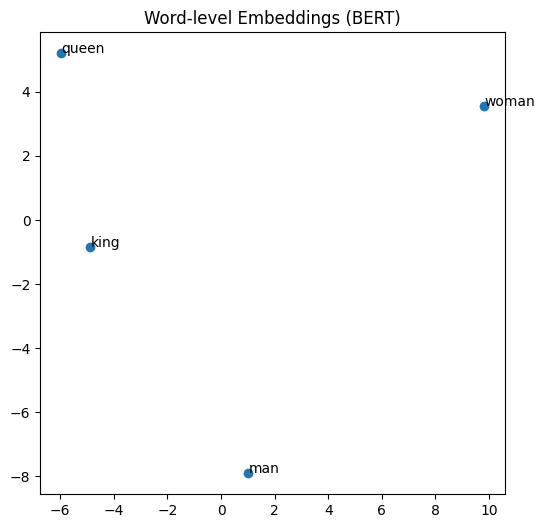

In [ ]:


# Load pre-trained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

words = ["man", "woman", "king", "queen"]
word_embeddings = []

# Process each word individually
for word in words:
    # Tokenize the single word and get the token IDs
    # `add_special_tokens=False` is crucial here to avoid [CLS] and [SEP]
    inputs = tokenizer(word, return_tensors='pt', add_special_tokens=False)

    # Get the token embeddings from the model
    with torch.no_grad():
        outputs = model(**inputs)
        # The output is a tensor of shape (1, num_tokens, hidden_size)
        token_embeddings = outputs.last_hidden_state

    # Average the subword tokens for each word
    # For a single word like "man" or "king", this will often just be one token.
    # For a multi-token word like "running" -> ["run", "##ning"], this averages them.
    word_embedding = token_embeddings.mean(dim=1)
    word_embeddings.append(word_embedding.squeeze())

# Stack the list of tensors into a single tensor
word_embeddings = torch.stack(word_embeddings)

# PCA for 2D visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(word_embeddings.numpy())

plt.figure(figsize=(6,6))
plt.scatter(reduced[:,0], reduced[:,1])
for i, word in enumerate(words):
    plt.annotate(word, (reduced[i,0]+0.01, reduced[i,1]+0.01))
plt.title("Word-level Embeddings (BERT)")
plt.show()


## Generating contextualized Word Embeddings with BERT

BERT (Bidirectional Encoder Representations from Transformers) generates contextual embeddings, where a word's representation depends on its sentence context (e.g., "king" in "The king ruled the kingdom" vs. "He bought a king-sized bed"). This section demonstrates how to generate and inspect word and sentence embeddings using BERT.



### Tokenizing and Extracting Embeddings

We use the `bert-base-uncased` model to tokenize a sentence and extract token-level and sentence-level embeddings. The process involves:
1. Tokenizing the input sentence.
2. Passing tokens through BERT to obtain the last hidden state.
3. Computing a sentence embedding by averaging token embeddings (excluding special tokens like `[CLS]` and `[SEP]`).


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# ---------------------------------
# Load pre-trained BERT tokenizer and model
# ---------------------------------
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# ---------------------------------
# Process sentences in a single batch
# ---------------------------------
sentences = [
    "The king ruled the kingdom.",
    "He bought a king-sized bed."
]

inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
print(f"inputs:\n{inputs}")

with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state

# Get all tokens for the batch
tokens_batch = [tokenizer.convert_ids_to_tokens(ids) for ids in inputs["input_ids"]]

# ---------------------------------
# Part 2: Extract and print 'king' embeddings
# ---------------------------------
for i, sentence_tokens in enumerate(tokens_batch):
    print("\n" + "="*50)
    print(f"Sentence {i+1}: {sentences[i]}")
    print(f"Tokens: {sentence_tokens}")

    # Find the index of the "king" token in the current sentence
    # This will be different for each sentence due to padding and context
    try:
        king_index = sentence_tokens.index("king")

        # Get the embedding for 'king'
        king_embedding = last_hidden_state[i, king_index, :]

        print(f"Index of 'king' token: {king_index}")
        print(f"Token embedding shape: {king_embedding.shape}")
        print(f"Embedding (first 5 dims): {king_embedding[:5]}")

    except ValueError:
        print("The token 'king' was not found in this sentence. It may have been tokenized as a subword.")

inputs:
{'input_ids': tensor([[ 101, 1996, 2332, 5451, 1996, 2983, 1012,  102,    0,    0],
        [ 101, 2002, 4149, 1037, 2332, 1011, 7451, 2793, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Sentence 1: The king ruled the kingdom.
Tokens: ['[CLS]', 'the', 'king', 'ruled', 'the', 'kingdom', '.', '[SEP]', '[PAD]', '[PAD]']
Index of 'king' token: 2
Token embedding shape: torch.Size([768])
Embedding (first 5 dims): tensor([0.2076, 0.3010, 0.1696, 0.0659, 0.0490])

Sentence 2: He bought a king-sized bed.
Tokens: ['[CLS]', 'he', 'bought', 'a', 'king', '-', 'sized', 'bed', '.', '[SEP]']
Index of 'king' token: 4
Token embedding shape: torch.Size([768])
Embedding (first 5 dims): tensor([ 0.2688, -0.3023,  1.2411,  0.3168,  0.0970])


## [PAD] tokens in transformers:

    Are masked during attention: they neither attend to other tokens nor are attended to.

    Still have a token embedding for consistency and pipeline convenience.

    Different pad tokens in a sequence can have different final embeddings because of positional embeddings, even though the token embedding itself is the same.

## [SEP] token:

    Not masked; it can attend to other tokens and be attended to.

    Has its own embedding and is used to separate segments or pool information.

In [ ]:
# Show embedding for each token
print("\n=== Token Embeddings (first 5 dims each) ===")
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
for i, tok in enumerate(tokens):
    print(f"{tok:>6} -> {last_hidden_state[0, i, :5]}")  # print first 5 dims

# Sentence embedding by averaging (excluding CLS, SEP)
sentence_embedding = last_hidden_state[:, 1:-1, :].mean(dim=1)
print("\n=== Sentence Embedding ===")
print(f"Shape: {sentence_embedding.shape}")
print(f"First 10 dims: {sentence_embedding[0, :10]}")


=== Token Embeddings (first 5 dims each) ===
 [CLS] -> tensor([-0.2794,  0.1900, -0.1530,  0.3762, -0.8679])
   the -> tensor([-0.2522, -0.1426, -0.4458,  0.5366, -0.4385])
  king -> tensor([0.2076, 0.3010, 0.1696, 0.0659, 0.0490])
 ruled -> tensor([ 0.1841,  0.0911, -0.2292,  0.0992, -0.5676])
   the -> tensor([-0.1104, -0.3182, -0.0161,  0.0779, -0.2205])
kingdom -> tensor([ 0.1134, -0.2636,  0.2714, -0.0763,  0.2711])
     . -> tensor([ 0.1278, -0.4396,  0.2093,  0.4143, -0.6122])
 [SEP] -> tensor([ 0.5756, -0.0774, -0.0939,  0.9288, -0.5347])
 [PAD] -> tensor([ 0.1760,  0.0579,  0.3439,  0.3191, -0.2008])
 [PAD] -> tensor([-0.2318, -0.1785,  0.3250,  0.3355, -0.4541])

=== Sentence Embedding ===
Shape: torch.Size([2, 768])
First 10 dims: tensor([ 0.1277, -0.0989,  0.0262,  0.2957, -0.2818, -0.0512, -0.0099,  0.5512,
        -0.1027, -0.3005])


In [ ]:
# -------------------------------
# Process both sentences together to show token type IDs
# -------------------------------
sentence1 = sentences[0]
sentence2 = sentences[1]
sentence1 = "The king ruled the kingdom."
sentence2 = "He bought a king-sized bed."

# Tokenize as a pair. This adds a [SEP] between them and a [CLS] at the start.
inputs = tokenizer(sentence1, sentence2, return_tensors="pt", padding=True, truncation=True)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

print("\n--- Tokenization Details ---")
print(f"Tokens: {tokens}")
print(f"Input IDs: {inputs['input_ids']}")
print(f"Token Type IDs: {inputs['token_type_ids']}")
print(f"Attention Mask: {inputs['attention_mask']}")

with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state

# Extract and compare embeddings for "king" from both sentences
print("\n--- Comparing 'king' Embeddings in Context ---")
king_indices_s1 = [i for i, type_id in enumerate(inputs["token_type_ids"][0]) if tokens[i] == "king" and type_id == 0]
king_indices_s2 = [i for i, type_id in enumerate(inputs["token_type_ids"][0]) if tokens[i] == "king" and type_id == 1]

if king_indices_s1:
    king_embedding_s1 = last_hidden_state[0, king_indices_s1[0], :]
    print(f"Embedding of 'king' in sentence 1 (index {king_indices_s1[0]}):")
    print(f"First 5 dims: {king_embedding_s1[:5]}")

if king_indices_s2:
    king_embedding_s2 = last_hidden_state[0, king_indices_s2[0], :]
    print(f"Embedding of 'king' in sentence 2 (index {king_indices_s2[0]}):")
    print(f"First 5 dims: {king_embedding_s2[:5]}")


--- Tokenization Details ---
Tokens: ['[CLS]', 'the', 'king', 'ruled', 'the', 'kingdom', '.', '[SEP]', 'he', 'bought', 'a', 'king', '-', 'sized', 'bed', '.', '[SEP]']
Input IDs: tensor([[ 101, 1996, 2332, 5451, 1996, 2983, 1012,  102, 2002, 4149, 1037, 2332,
         1011, 7451, 2793, 1012,  102]])
Token Type IDs: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

--- Comparing 'king' Embeddings in Context ---
Embedding of 'king' in sentence 1 (index 2):
First 5 dims: tensor([ 0.1483, -0.0045,  0.3489,  0.1108,  0.2760])
Embedding of 'king' in sentence 2 (index 11):
First 5 dims: tensor([-0.4196, -0.3937,  1.3084,  0.1102,  0.3744])


# Sentence Embeddings with Sentence Transformers

## Purpose
- Represent entire sentences as a single vector.
- **Why**: Captures semantic meaning; similar sentences are positioned close in vector space.
- **Efficiency**: Produces one vector per sentence, faster than token-level embeddings for tasks like semantic search or neural ranking.
- **Applications**: Semantic search, clustering, paraphrase detection, neural ranking.

## How did we do it in BERT?
### [CLS] Token in BERT
- **Role**: Added at the start of every input sequence.
- **Function**: Its embedding summarizes the sentence, often used for **classification** tasks (e.g., **sentiment analysis, entailment**).
- **Contextual**: Absorbs information from all tokens in the sequence.
- **Usage**: Can serve as a rough sentence embedding, but Sentence Transformers are better optimized for semantic similarity tasks.
###or we did mean pooling on top of last hidden output


## Relation to BERT and Token-level Embeddings

### Token-level Embeddings (BERT)
- **Characteristics**: Generates embeddings per token, which are contextual and vary based on surrounding words.
- **Sentence-level Embedding**: Can be derived by averaging token embeddings or using the [CLS] token, but this is not optimized for similarity tasks.

### Sentence-level Embeddings (Sentence Transformers)
- **Characteristics**: Built on BERT/RoBERTa, fine-tuned specifically for semantic similarity.
- **Output**: Maps full sentences to a single vector.
- **Advantages**: Highly efficient for tasks requiring one vector per sentence, such as semantic search or clustering.

## Sentence-level Embeddings with Sentence Transformers

* Produces one vector per sentence optimized for semantic similarity.

* Built on BERT/RoBERTa but fine-tuned on ***semantic tasks***.

* Much more efficient for semantic search, clustering, or neural ranking.

* Example: visualize embeddings of the same words as “sentences” (or short phrases) using Sentence Transformers.

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

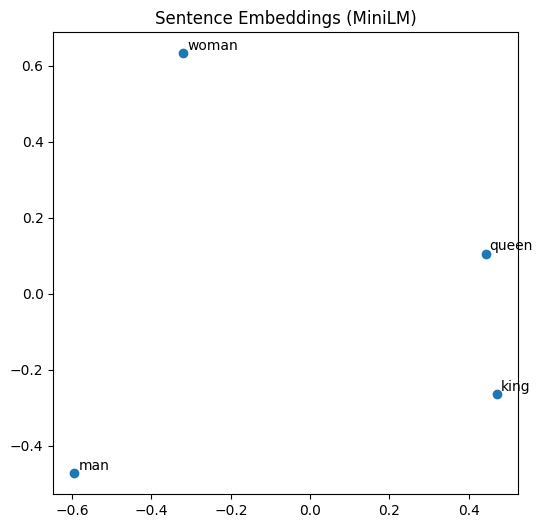

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
sentences = ["man", "woman", "king", "queen"]

sentence_embeddings = model.encode(sentences)

# PCA for 2D visualization
reduced = PCA(n_components=2).fit_transform(sentence_embeddings)

plt.figure(figsize=(6,6))
plt.scatter(reduced[:,0], reduced[:,1])
for i, word in enumerate(sentences):
    plt.annotate(word, (reduced[i,0]+0.01, reduced[i,1]+0.01))
plt.title("Sentence Embeddings (MiniLM)")
plt.show()


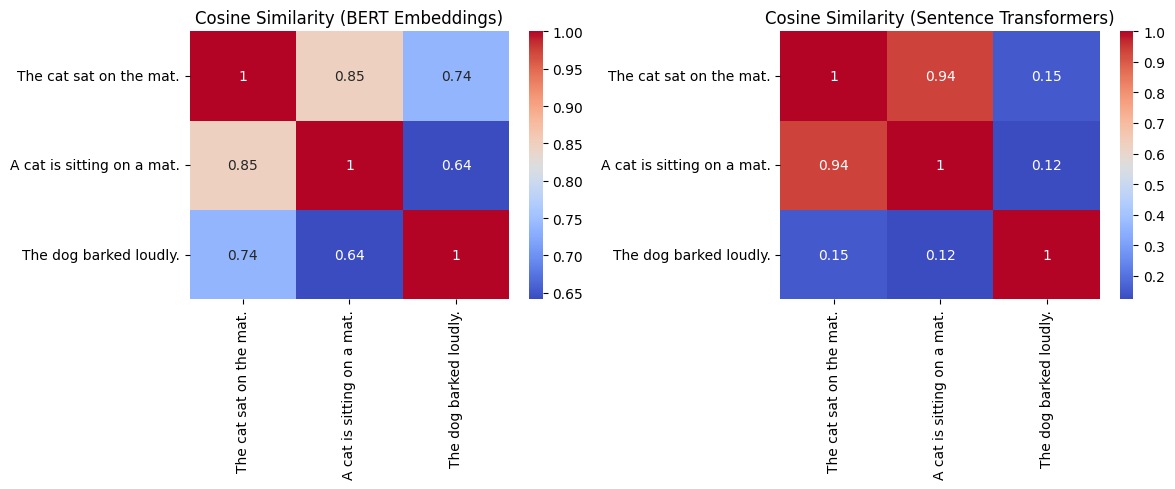

In [ ]:


# Example sentences
sentences = [
    "The cat sat on the mat.",
    "A cat is sitting on a mat.",
    "The dog barked loudly."
]

# ---- BERT token-level embeddings (average tokens) ----
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)
    token_embeddings = outputs.last_hidden_state
    sent_embeddings_bert = token_embeddings[:, 1:-1, :].mean(dim=1)  # Average over tokens

# ---- Sentence Transformers embeddings ----
st_model = SentenceTransformer("all-MiniLM-L6-v2")
sent_embeddings_st = st_model.encode(sentences)

# Calculate cosine similarities
cos_sim_bert = util.cos_sim(sent_embeddings_bert, sent_embeddings_bert).cpu().numpy()
cos_sim_st = util.cos_sim(sent_embeddings_st, sent_embeddings_st).cpu().numpy()

# Plot heatmaps
plt.figure(figsize=(12, 5))

# BERT cosine similarity heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cos_sim_bert, annot=True, xticklabels=sentences, yticklabels=sentences, cmap="coolwarm")
plt.title("Cosine Similarity (BERT Embeddings)")

# Sentence Transformers cosine similarity heatmap
plt.subplot(1, 2, 2)
sns.heatmap(cos_sim_st, annot=True, xticklabels=sentences, yticklabels=sentences, cmap="coolwarm")
plt.title("Cosine Similarity (Sentence Transformers)")

plt.tight_layout()
plt.show()

**Bi-Encoder Model for Neural Ranking**

Bi-encoder models are designed for efficient neural ranking by independently encoding queries and documents into fixed-dimensional vectors, typically using transformer-based architectures. These vectors can be compared using cosine similarity, defined as cos_sim(q, d) = (q · d) / (||q|| ||d||), to rank documents by relevance. In this cell, we use the Sentence Transformers library with the 'all-MiniLM-L6-v2' model, which is optimized for generating sentence embeddings. We encode a sample query and a set of documents, compute their cosine similarities, and rank the documents based on these scores. This approach is ideal for large-scale retrieval because document embeddings can be pre-computed and indexed.

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

# ==========================
# Load Bi-Encoder Model
# ==========================
bi_encoder = SentenceTransformer("all-MiniLM-L6-v2")

# ==========================
# Example Query & Documents
# ==========================
query = "best hiking trails"
documents = [
    "Top 10 hiking trails in the mountains with scenic views.",
    "A guide to urban parks and walking paths.",
    "Best trails for beginner hikers near the city.",
    "How to cook pasta at home."
]

# ==========================
# Precompute Document Embeddings
# ==========================
# This is what makes bi-encoders scalable: we can store these embeddings once
doc_embs = bi_encoder.encode(documents, convert_to_tensor=True)

# ==========================
# Encode Query
# ==========================
query_emb = bi_encoder.encode(query, convert_to_tensor=True)

# ==========================
# Compute Cosine Similarity
# ==========================
cosine_scores = util.cos_sim(query_emb, doc_embs)  # shape: [1, num_docs]

# ==========================
# Retrieve Top-K Documents
# ==========================
top_k = 3
top_results = torch.topk(cosine_scores, k=top_k)

print("\n=== Bi-Encoder Ranking (Top 3) ===")
for score, idx in zip(top_results.values[0], top_results.indices[0]):
    print(f"Score: {score:.4f} | {documents[idx]}")

# ==========================
# Optional: Show all scores
# ==========================
print("\n=== All Scores ===")
for doc, score in zip(documents, cosine_scores[0].tolist()):
    print(f"Score: {score:.4f} | {doc}")



=== Bi-Encoder Ranking (Top 3) ===
Score: 0.8135 | Best trails for beginner hikers near the city.
Score: 0.7481 | Top 10 hiking trails in the mountains with scenic views.
Score: 0.5237 | A guide to urban parks and walking paths.

=== All Scores ===
Score: 0.7481 | Top 10 hiking trails in the mountains with scenic views.
Score: 0.5237 | A guide to urban parks and walking paths.
Score: 0.8135 | Best trails for beginner hikers near the city.
Score: -0.0080 | How to cook pasta at home.


## Cross-Encoder Model for Neural Ranking

Cross-encoder models improve ranking accuracy by jointly encoding a query and a document into a single representation and directly predicting a relevance score. Unlike Bi-Encoders, which compute embeddings independently, Cross-Encoders consider the interaction between the query and document tokens, typically using transformer-based architectures. This allows the model to capture fine-grained semantic relationships, making it highly effective for ranking tasks.


The trade-off is efficiency: Cross-Encoders are slower for large-scale retrieval because each query-document pair must be evaluated separately. Therefore, they are often used to re-rank top-k candidates retrieved by a Bi-Encoder.

In [ ]:
# ==========================
# Cross-Encoder Example for Neural Ranking
# ==========================
from sentence_transformers import CrossEncoder, util
import torch

# 1. Load a pretrained Cross-Encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
# print("Loaded Cross-Encoder:", cross_encoder)

# 2. Define query and candidate documents
query = "best hiking trails"
documents = [
    "Top 10 hiking trails in the mountains with scenic views.",
    "A guide to urban parks and walking paths.",
    "Best trails for beginner hikers near the city.",
    "How to cook pasta at home."
]

# 3. Prepare input pairs (query, document)
pairs = [(query, doc) for doc in documents]

# 4. Compute relevance scores
scores = cross_encoder.predict(pairs)

# 5. Rank documents by score
ranked_docs = sorted(zip(documents, scores), key=lambda x: x[1], reverse=True)

# 6. Display results
print("\n=== Cross-Encoder Ranking ===")
for doc, score in ranked_docs:
    print(f"Score: {score:.4f} | {doc}")

# ==========================
# Notes:
# - Cross-Encoders are more accurate than Bi-Encoders but slower at scale.
# - Ideal for re-ranking top-k candidates retrieved by a Bi-Encoder.
# ==========================


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


=== Cross-Encoder Ranking ===
Score: 5.2127 | Top 10 hiking trails in the mountains with scenic views.
Score: 4.1777 | Best trails for beginner hikers near the city.
Score: -9.5556 | A guide to urban parks and walking paths.
Score: -11.1704 | How to cook pasta at home.


Now, lets fine tune the bi-encoder model to perform better:

We want to make the model to predict a higher score for relevant/similar query-document pairs and a lower score for non relevant/non similar pairs.

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

# 1. Load a good pretrained model
model = SentenceTransformer("bert-base-uncased")
print("Loaded model:", model)

# 2. Create toy training data (Query -> Positive passage)
train_examples = [
    InputExample(texts=["scenic mountain hiking", "Top 10 hiking trails in the mountains"]),
    InputExample(texts=["beginner-friendly city trails", "Best trails for beginner hikers near the city"]),
    InputExample(texts=["easy trails near urban parks", "A guide to urban parks and walking paths"]),
    InputExample(texts=["pasta recipes for beginners", "How to cook pasta at home"]),
]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)

# 3. Use MultipleNegativesRankingLoss
train_loss = losses.MultipleNegativesRankingLoss(model)

# ===============================
# Test data
# ===============================
queries = [
    "scenic mountain hiking",
    "beginner-friendly city trails",
    "easy trails near urban parks",
    "pasta recipes for beginners"
]

documents = [
    "Top 10 hiking trails in the mountains",
    "Best trails for beginner hikers near the city",
    "A guide to urban parks and walking paths",
    "How to cook pasta at home"
]

def evaluate(model, queries, docs, title):
    query_embs = model.encode(queries, convert_to_tensor=True)
    doc_embs = model.encode(docs, convert_to_tensor=True)
    scores = util.cos_sim(query_embs, doc_embs)
    print(f"\n=== {title} ===")
    for i, q in enumerate(queries):
        print(f"\nQuery: {q}")
        ranked = sorted(zip(docs, scores[i]), key=lambda x: x[1], reverse=True)
        for doc, score in ranked:
            print(f"  Score: {score:.4f} | {doc}")

# 4. Evaluate BEFORE fine-tuning
evaluate(model, queries, documents, "Ranking BEFORE fine-tuning")

# 5. Fine-tune the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=10,
    show_progress_bar=True
)

# 6. Evaluate AFTER fine-tuning
evaluate(model, queries, documents, "Ranking AFTER fine-tuning")


Loaded model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

=== Ranking BEFORE fine-tuning ===

Query: scenic mountain hiking
  Score: 0.7803 | Top 10 hiking trails in the mountains
  Score: 0.7167 | Best trails for beginner hikers near the city
  Score: 0.5990 | A guide to urban parks and walking paths
  Score: 0.5366 | How to cook pasta at home

Query: beginner-friendly city trails
  Score: 0.8024 | Best trails for beginner hikers near the city
  Score: 0.7408 | Top 10 hiking trails in the mountains
  Score: 0.7137 | A guide to urban parks and walking paths
  Score: 0.5302 | How to cook pasta at home

Query: easy trails 

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: naghmefarzi (naghmefarzi-university-of-new-hampshire) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss



=== Ranking AFTER fine-tuning ===

Query: scenic mountain hiking
  Score: 0.7584 | Top 10 hiking trails in the mountains
  Score: 0.6944 | Best trails for beginner hikers near the city
  Score: 0.5665 | A guide to urban parks and walking paths
  Score: 0.5080 | How to cook pasta at home

Query: beginner-friendly city trails
  Score: 0.8228 | Best trails for beginner hikers near the city
  Score: 0.7316 | A guide to urban parks and walking paths
  Score: 0.6844 | Top 10 hiking trails in the mountains
  Score: 0.5040 | How to cook pasta at home

Query: easy trails near urban parks
  Score: 0.8260 | A guide to urban parks and walking paths
  Score: 0.7545 | Best trails for beginner hikers near the city
  Score: 0.6440 | Top 10 hiking trails in the mountains
  Score: 0.5281 | How to cook pasta at home

Query: pasta recipes for beginners
  Score: 0.7829 | How to cook pasta at home
  Score: 0.6103 | Best trails for beginner hikers near the city
  Score: 0.5723 | A guide to urban parks and w

In [ ]:
!pip install faiss-cpu

import faiss
import torch
import numpy as np
from sentence_transformers import SentenceTransformer, util

# -------------------------
# Load model
# -------------------------
bi_encoder = SentenceTransformer("all-MiniLM-L6-v2")
# Get the underlying transformer model
model = bi_encoder._first_module().auto_model
tokenizer = bi_encoder.tokenizer

# -------------------------
# Example query and documents
# -------------------------
query = "best hiking trails"
documents = [
    "Top 10 hiking trails in the mountains with scenic views.",
    "A guide to urban parks and walking paths.",
    "Best trails for beginner hikers near the city.",
    "How to cook pasta at home."
]

# -------------------------
# Tokenize and encode
# -------------------------
with torch.no_grad():
    # Query tokens
    q_tokens = tokenizer(query, return_tensors="pt", truncation=True, padding=True)
    # Get token embeddings, ignoring the [CLS] token at the beginning
    q_embs = model(**q_tokens).last_hidden_state[0, 1:]  # (q_len, hidden)

    # Document tokens
    # Note: For simplicity, we keep the one-by-one encoding.
    # A fully optimized version would batch this and handle padding carefully.
    d_embs_list = []
    for doc in documents:
        doc_toks = tokenizer(doc, return_tensors="pt", truncation=True, padding=True)
        # Get token embeddings, ignoring the [CLS] token
        doc_embs = model(**doc_toks).last_hidden_state[0, 1:]
        d_embs_list.append(doc_embs)

# -------------------------
# Build ANN index for all document tokens
# -------------------------
hidden_dim = q_embs.shape[1]
# Keep track of which document each token belongs to
token_to_doc_id = []
for i, d_emb in enumerate(d_embs_list):
    token_to_doc_id.extend([i] * d_emb.shape[0])

all_doc_tokens = torch.cat(d_embs_list, dim=0).cpu().numpy()
# Faiss requires a contiguous array
all_doc_tokens = np.ascontiguousarray(all_doc_tokens)

# Normalize vectors for cosine similarity search with IndexFlatIP
faiss.normalize_L2(all_doc_tokens)

index = faiss.IndexFlatIP(hidden_dim)
index.add(all_doc_tokens)

# -------------------------
# Query ANN (Late Interaction)
# -------------------------
q_embs_np = q_embs.cpu().numpy()
q_embs_np = np.ascontiguousarray(q_embs_np)
faiss.normalize_L2(q_embs_np)

# For each query token, find the k nearest document tokens
k = 10 # Increase k to ensure we get matches from all relevant docs
distances, indices = index.search(q_embs_np, k)

# -------------------------
# Aggregate scores per document (The ColBERT MaxSim Logic)
# -------------------------
doc_scores = torch.zeros(len(documents))

# For each query token
for q_idx in range(len(q_embs_np)):
    # Find the max similarity for this query token *per document*
    max_sim_per_doc = {} # Resets for each query token

    # For each of the k nearest document tokens
    for hit_idx, score in zip(indices[q_idx], distances[q_idx]):
        if hit_idx == -1: continue # Faiss can return -1 for no result

        doc_id = token_to_doc_id[hit_idx]
        # If we find a better scoring token for this document, update it
        if doc_id not in max_sim_per_doc or score > max_sim_per_doc[doc_id]:
            max_sim_per_doc[doc_id] = score

    # Add the max scores for this query token to the total document scores
    for doc_id, score in max_sim_per_doc.items():
        doc_scores[doc_id] += score

# -------------------------
# Rank documents
# -------------------------
# Convert to list for sorting
ranked = sorted(zip(documents, doc_scores.tolist()), key=lambda x: x[1], reverse=True)

print("\n=== ColBERT + ANN Ranking (Corrected) ===")
for doc, score in ranked:
    print(f"Score: {score:.4f} | {doc}")


=== ColBERT + ANN Ranking (Corrected) ===
Score: 3.5709 | Best trails for beginner hikers near the city.
Score: 3.0353 | Top 10 hiking trails in the mountains with scenic views.
Score: 1.6543 | A guide to urban parks and walking paths.
Score: 0.0000 | How to cook pasta at home.
